# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1tGcX2qzS2GoaN5zFeD5DVJxqDmoQdmMs7QncZwFCEqU/edit#)_

_This scaffolding notebook may be used to help setup your final project. It's totally optional whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add prose and code as you wish._

_Anything in italics (prose) or comments (in code) is meant to provide you with guidance. **Remove the italic lines and provided comments** before submitting the project, if you choose to use this scaffolding. We don't need the guidance when grading._

_All code should be consider "pseudo-code" - not functional by itself, and only a suggestion at the approach._

## Requirements

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project._

* Code clarity: make sure the code conforms to:
    * [ ] [PEP 8](https://peps.python.org/pep-0008/) - You might find [this resource](https://realpython.com/python-pep8/) helpful as well as [this](https://github.com/dnanhkhoa/nb_black) or [this](https://jupyterlab-code-formatter.readthedocs.io/en/latest/) tool
    * [ ] [PEP 257](https://peps.python.org/pep-0257/)
    * [ ] Break each task down into logical functions
* The following files are submitted for the project (see the project's GDoc for more details):
    * [ ] `README.md`
    * [ ] `requirements.txt`
    * [ ] `.gitignore`
    * [ ] `schema.sql`
    * [ ] 6 query files (using the `.sql` extension), appropriately named for the purpose of the query
    * [x] Jupyter Notebook containing the project (this file!)
* [x] You can edit this cell and add a `x` inside the `[ ]` like this task to denote a completed task

## Project Setup

In [2]:
# all import statements needed for the project, for example:

import math

from os.path import exists
import bs4
import matplotlib.pyplot as plt
import pandas as pd
import requests
import sqlalchemy as db
import json
import numpy as np
import scipy.stats as t
from scipy.stats import norm
from keplergl import KeplerGl

In [3]:
# any general notebook setup, like log formatting

In [4]:
# any constants you might need, for example:

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
# add other constants to refer to any local data, e.g. uber & weather
UBER_CSV = "uber_rides_sample.csv"

NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

## Part 1: Data Preprocessing

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Define a function that calculates the distance between two coordinates in kilometers that **only uses the `math` module** from the standard library
* [ ] Write at least one unit test that tests this distance calculation function. 
* Taxi data:
    * [ ] Use `requests`, BeautifulSoup (`bs4`), and `pandas` to programmatically download the required CSV files & load into memory.
    * [ ] Clean the data, including:
        * Remove unnecessary columns
        * Remove invalid data points (take a moment to consider what's invalid)
        * Normalize column names
        * Remove trips that start and/or end outside the designated [coordinate box](http://bboxfinder.com/#40.560445,-74.242330,40.908524,-73.717047)
    * [ ] Sample the data so that you have roughly the same amount of data points over the given date range for both Taxi data and Uber data.
    * You may need to do this one file at a time - download, clean, sample. You can cache the sampling by saving it as a CSV file (and thereby freeing up memory on your computer) before moving onto the next file. 
* Uber data:
    * [ ] Download the data manually in the link provided in the project doc.
    * [ ] Load the data from your local computer (using `pandas`), then clean the data, including: 
        * Remove unnecessary columns
        * Remove invalid data points (take a moment to consider what's invalid)
        * Normalize column names
        * Remove trips that start and/or end outside the designated [coordinate box]
* Using the function that calculates the distance between two coordinates in kilometers, add a column to each `pandas` DataFrame of data that calculates the distance between pickup and dropoff locations for each trip.
* Weather data:
    * [ ] Download the data manually in the link provided in the project doc.
    * [ ] Load the data from your local computer (using `pandas`), then clean the data, including: 
        * Remove unnecessary columns
        * Remove invalid data points (take a moment to consider what's invalid)
        * Normalize column names
        * Split into two `pandas` DataFrames: one for required hourly data, and one for the required daily daya.
        * You may find that the weather data you need later on does not exist at the frequency needed (daily vs hourly). You may calculate/generate samples from one to populate the other. Just document what you’re doing so we can follow along. 
* Take a look at the lecture notes from the `pandas` lecture for hints on helpful functionality

### Calculating distance
_Converting the start and end longitude and latitude coordinates into a distance in Km._

In [5]:
from math import sin, cos, sqrt, atan2, radians

def calculate_distance(from_coord, to_coord):
    '''
    @param from_coord: Tuple of latitud/longitude coordinates in degrees
    @param to_coord: Tuple of latitud/longitude coordinates in degrees
    
    @return Distance between two coordinates in Km
    '''
   

    # approximate radius of earth in km
    R = 6371.0

    lat1 = radians(from_coord[0])
    lon1 = radians(from_coord[1])
    lat2 = radians(to_coord[0])
    lon2 = radians(to_coord[1])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance



In [6]:

def test_calculate_distance():
    '''
    Tests the above code to make sure distance is calculated correctly 
    '''
    expected = 58.79508979190137
    actual = calculate_distance(NEW_YORK_BOX_COORDS[0], NEW_YORK_BOX_COORDS[1])
    assert actual == expected
test_calculate_distance()

In [7]:

def add_distance_column(dataframe):
    '''
    Here we will add a distance column to our dataframe with the newly calculated distances
    @param dataframe: dataframe to add distance column to
    @return returns dataframe with new distance column
    '''
    distances = []
    for index, row in dataframe.iterrows():
        distances.append(calculate_distance((row['pickup_longitude'], row['pickup_latitude']), (row['dropoff_longitude'], row['dropoff_latitude'])))
    print(distances)
    dataframe['distance'] = distances 
    return dataframe

### Processing Taxi Data

_Scrape, Download, Clean, and insert the relevant taxi data from the given website into a dataframe._

In [33]:

def find_taxi_csv_urls():
    '''
    Websrape the NY taxi data using BeautifulSoup to prettify the html 
    and make it readable

    @returns a list of hrefs from 01/2009 - 06/2015
    '''
    response = requests.get(TAXI_URL)
    soup = bs4.BeautifulSoup(response.text, "html.parser")
    a_tags = soup.find_all(lambda tag:tag.name == 'a' and 'title' in tag.attrs and tag.attrs['title'] == "Yellow Taxi Trip Records")
    hrefs = [a['href'] for a in a_tags]
    hrefs_years=[]
    year = 2009
    for i in range(1, 7):
        hrefs_years.extend(list( filter(lambda href: str(year) in href, hrefs)))
        year += 1
    hrefs_2015 = []
    hrefs_2015.extend(list( filter(lambda href: '2015' in href, hrefs)))
    for i in range(6):
        hrefs_2015.pop()
    all_hrefs = hrefs_years + hrefs_2015 
    return all_hrefs


def get_and_clean_month_taxi_data(url):
    '''
    Here, we will first normalize the data so we can create csv without interruption

    @param url: csv url to pull data from

    @return a dataframe with all lowercase and changed column names 
    '''
    df = pd.read_csv(url) 
    df.columns = df.columns.str.lower()
    if 'trip_dropoff_datetime' in df.columns: 
        df=df.rename(columns = {'fare_amt':'fare_amount'})
    
    if 'trip_pickup_datetime' in df.columns:
        df=df.rename(columns = {'trip_pickup_datetime':'pickup_datetime'})

    
    df.drop(df.columns.difference(['pickup_datetime', 'fare_amount', 'trip_distance']), 1, inplace=True)
    return df

 
def add_taxi_distance_column(dataframe):
    '''
    creates a trip distance column and converts values from miles to Km
    @param dataframe: dataframe to add taxi distance column to 
    @return the dataframe with the new column 
    '''  
    distances = []
    for index, row in dataframe.iterrows():
        distances.append(row['trip_distance'] * 1.60934)
    dataframe['trip_distance'] = distances    
    return dataframe

  
def get_and_clean_taxi_data():
    '''
    this function retrieves the scraped webpage of taxi data (monthly) 
    and inputs into a dataframe and saves as a csv 

    @return the comprehensive dataframe of taxi data
    '''  
    all_taxi_dataframes = []
    
    all_csv_urls = find_taxi_csv_urls()
    for csv_url in all_csv_urls:
        
        if exists(f'taxi_data_{all_csv_urls.index(csv_url)}.csv'):
            dataframe = pd.read_csv(f'taxi_data_{all_csv_urls.index(csv_url)}.csv')
            
        else:
            dataframe = get_and_clean_month_taxi_data(csv_url)
            dataframe = dataframe.sample(n=2500, random_state=2)
            add_taxi_distance_column(dataframe)
            dataframe.to_csv(f'taxi_data_{all_csv_urls.index(csv_url)}.csv', index=False)
     
        
        all_taxi_dataframes.append(dataframe)
        
    # create one gigantic dataframe with data from every month needed
    taxi_data = pd.concat(all_taxi_dataframes)
    return taxi_data



https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2009-01.csv


OverflowError: signed integer is greater than maximum

### Processing Uber Data

_In this section, we will be filtering and cleaning the Uber data to prep for analysis._

In [8]:
def load_and_clean_uber_data(csv_file):

    '''
    First, we will load the Uber data and drop the columns that aren't needed
    After that, we will filter for trips that are strictly in the given coordinates
    @param csv file: a csv with the uber data to be cleaned
    @return a dataframe with the clean and filtered Uber data
    '''

    df = pd.read_csv(csv_file)
    df.drop(['passenger_count', 'key', 'fare_amount'], axis = 1, inplace = True)
    df = df.iloc[: , 1:]
    df.drop(df[df['pickup_longitude'] < -74.242330].index.intersection(df[df['pickup_longitude'] > -73.717047].index), inplace=True)
    df.drop(df[df['dropoff_longitude'] < -74.242330].index.intersection(df[df['dropoff_longitude'] > -73.717047].index), inplace=True)
    df.drop(df[df['pickup_latitude'] < 40.560445].index.intersection(df[df['pickup_latitude'] > 40.908524].index), inplace=True)
    df.drop(df[df['dropoff_latitude'] < 40.560445].index.intersection(df[df['dropoff_latitude'] > 40.908524].index), inplace=True)
    return df
    
def get_uber_data():
    '''
    @return the complete cleaned uber dataframe with the distance column
    '''
    uber_dataframe = load_and_clean_uber_data(UBER_CSV)
    add_distance_column(uber_dataframe)
    return uber_dataframe


### Processing Weather Data

_Scrape and clean weather data daily and monthly then load it into CSVs._

In [9]:
def clean_month_weather_data_hourly(csv_file):
    '''
    @difference drops all columns except the ones we want for analysis

    we then clean the data and make sure there are no invalid rows or columns

    @return a dataframe with the average hourly wind speed
    '''
    df = pd.read_csv(csv_file)
    df.drop(df.columns.difference(['DATE','HourlyPrecipitation', 'HourlyWindSpeed']), 1, inplace=True)
    df['HourlyPrecipitation'] = df['HourlyPrecipitation'].replace('T', 0.00)
    df['HourlyPrecipitation'] = df['HourlyPrecipitation'].str.replace(r's', '')
    df['HourlyPrecipitation'] = df['HourlyPrecipitation'].fillna(0.00)
    df['HourlyWindSpeed'] = df['HourlyWindSpeed'].fillna(df['HourlyWindSpeed'].astype(float).mean())
    return df
    
def clean_month_weather_data_daily(csv_file):
    '''
    here we will be cleaning the data by day instead of hourly as we did previously and
    then returning the daily mean on the data
    '''

    df = pd.read_csv(csv_file)
    df.drop(df.columns.difference(['DATE','DailyAverageWindSpeed']), 1, inplace=True)
    df = df[df.DATE.str.contains("23:59:00")]
    df['DailyAverageWindSpeed'] = df['DailyAverageWindSpeed'].fillna(df['DailyAverageWindSpeed'].astype(float).mean())
    return df
    

def load_and_clean_weather_data():
    '''
    after cleaning the weather data by hour and day, we are ready to load
    in data and save into csv's

    @return two dataframes with hourly and daily data from each month
    '''
    hourly_dataframes = []
    daily_dataframes = []
    
    # add some way to find all weather CSV files
    # or just add the name/paths manually
    weather_csv_files = \
        [
            "weather/weather_2009.csv",
            "weather/weather_2010.csv",
            "weather/weather_2011.csv",
            "weather/weather_2012.csv",
            "weather/weather_2013.csv",
            "weather/weather_2014.csv",
            "weather/weather_2015.csv"
        ]
    
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    return hourly_data, daily_data


### Process All Data

_This is where you can actually execute all the required functions._

_Here is where the functions will be executed. Please note that the taxi data will error out due to size and RAM contraints, however the code is fully functional and given enough RAM, will create CSVs with all the necessary data._

In [10]:
taxi_data = get_and_clean_taxi_data()
uber_data = get_uber_data()
hourly_weather, daily_weather = load_and_clean_weather_data()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/var/folders/bd/k3x2fr1d0qnb1y68htn6g7wc0000gn/T/ipykernel_32436/133158462.py:40: DtypeWarning: Columns (9,13,41,64,78) have mixed types.Specify dtype option on import or set low_memory=False.
  hourly_dataframe = clean_month_weather_data_hourly(csv_file)
/var/folders/bd/k3x2fr1d0qnb1y68htn6g7wc0000gn/T/ipykernel_32436/133158462.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop(df.columns.difference(['DATE','HourlyPrecipitation', 'HourlyWindSpeed']), 1, inplace=True)
/var/folders/bd/k3x2fr1d0qnb1y68htn6g7wc0000gn/T/ipykernel_32436/133158462.py:41: DtypeWarning: Columns

In [11]:
taxi_data = pd.read_csv("/Users/sd/Desktop/4501/Project/sample_taxis.csv")

taxi_data = taxi_data.iloc[:,1:]
taxi_data.drop(taxi_data.columns[4], axis=1, inplace=True)
taxi_data.drop(taxi_data.columns[4], axis=1, inplace=True)
taxi_data.drop(taxi_data.columns[1], axis=1, inplace=True)
taxi_data.head()

,pickup_datetime,trip_distance,fare_amount
0,2015-01-23 11:24:57,2.64,16.30
1,2015-07-25 02:26:04,3.62,18.36
2,2012-03-27 12:24:16,2.30,11.28
3,2014-11-03 08:13:10,NaN,15.10
4,2011-02-12 22:04:00,0.00,3.50


## Part 2: Storing Cleaned Data

In this part, we'll create the connection and schema we need, and also create tables in the database.

In [12]:
engine = db.create_engine(DATABASE_URL)
import sqlite3
connection = sqlite3.connect("project.db")
connection

In [13]:
# if using SQL (as opposed to SQLAlchemy), define the commands 
# to create your 4 tables/dataframes
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather
(
    `DATE` DATE PRIMARY KEY,
    HourlyPrecipitation FLOAT,
    HourlyWindSpeed FLOAT
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather
(
    `DATE` DATE PRIMARY KEY,
    DailyAverageWindSpeed FLOAT
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_data
(
    pickup_datetime DATE PRIMARY KEY,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT,
    distance FLOAT
);
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_data
(
    pickup_datetime DATE PRIMARY KEY,
    trip_distance FLOAT,
    fare_amount FLOAT
);
"""

In [14]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [15]:
# create the tables with the schema files
connection = sqlite3.connect("project.db")
cursor = connection.cursor() 
with open(DATABASE_SCHEMA_FILE) as file:
    query = file.read()
    cursor.executescript(query)

### Add Data to Database

In this part, we'll load the data into the tables in the database.

In [16]:
hourly_weather.to_sql("hourly_weather", con=engine, if_exists="replace", index=False)
daily_weather.to_sql("daily_weather", con=engine, if_exists="replace", index=False)
uber_data.to_sql("uber_data", con=engine, if_exists="replace", index=False)
taxi_data.to_sql("taxi_data", con=engine, if_exists="replace", index=False)

In [17]:
with connection:
    result = connection.execute(
        "SELECT * FROM taxi_data LIMIT 5"
    )

for row in result:
    print(row)

('2015-01-23 11:24:57', 2.64, 16.3)
('2015-07-25 02:26:04', 3.62, 18.36)
('2012-03-27 12:24:16', 2.3, 11.28)
('2014-11-03 08:13:10', None, 15.1)
('2011-02-12 22:04:00', 0.0, 3.5)


In [ ]:
# def dataframes_to_table():
#     raise NotImplemented()

In [ ]:
# table_name_to_dataframe = {
#     "taxi_trips": taxi_data,
#     "uber_trips": uber_data,
#     "hourly_weather": hourly_data,
#     "daily_weather": daily_data,
# }

# dataframes_to_table(table_name_to_dataframe)

## Part 3: Understanding the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? The result should have 24 bins.
* [ ] For the same time frame, what day of the week was the most popular to take an uber? The result should have 7 bins.
* [ ] What is the 95% percentile of distance traveled for all hired trips during July 2013?
* [ ] What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?
* [ ] Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?
* [ ] During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

In [186]:
def write_query_to_file(query, outfile):
    with open(outfile, "w") as f:
        f.write(query)
        f.close()


### Query N

_Write some prose that tells the reader what you're about to do here._

_Repeat for each query_

In [195]:
QUERY_Q1 = '''SELECT strftime ('%H',pickup_datetime) AS Hour,
                    COUNT(strftime ('%H',pickup_datetime))
         FROM taxi_data
         WHERE pickup_datetime >= '2009-01-01 00:00:00'
         AND pickup_datetime <= '2015-06-30 23:59:59'
         AND trip_distance != 'None'
         GROUP BY Hour
         ORDER BY COUNT(strftime ('%H',pickup_datetime)) DESC
        '''

In [196]:
engine.execute(QUERY_Q1).fetchall()

[('19', 7526),
 ('18', 7196),
 ('20', 7123),
 ('21', 7070),
 ('22', 6728),
 ('14', 6149),
 ('23', 6031),
 ('17', 5993),
 ('12', 5985),
 ('13', 5852),
 ('15', 5838),
 ('11', 5631),
 ('09', 5571),
 ('10', 5528),
 ('08', 5449),
 ('16', 4983),
 ('00', 4704),
 ('07', 4407),
 ('01', 3557),
 ('02', 2651),
 ('06', 2494),
 ('03', 1979),
 ('04', 1379),
 ('05', 1180)]

In [221]:
write_query_to_file(QUERY_Q1, "Q1_taxi_hour_freq.sql")

In [198]:
QUERY_Q2 = '''SELECT strftime ('%w',datetime(substr(pickup_datetime, 1, 19))) AS Day,
                    COUNT(strftime ('%w',datetime(substr(pickup_datetime, 1, 19))))
        FROM uber_data
        WHERE pickup_datetime >= '2009-01-01 00:00:00'
        AND pickup_datetime <= '2015-06-30 23:59:59'
        GROUP BY Day
        ORDER BY COUNT(strftime ('%w',datetime(substr(pickup_datetime, 1, 19)))) DESC
        '''

In [199]:
engine.execute(QUERY_Q2).fetchall()

[('5', 30880),
 ('6', 30251),
 ('4', 30021),
 ('3', 29037),
 ('2', 28127),
 ('0', 26441),
 ('1', 25243)]

In [222]:
write_query_to_file(QUERY_Q2, "Q2_uber_weekday_freq.sql")

In [201]:
QUERY_Q3 = '''SELECT dis
        FROM(
        SELECT a.trip_distance AS dis
        FROM taxi_data AS a
        WHERE a.pickup_datetime >= '2013-07-01 00:00:00'
        AND a.pickup_datetime <= '2013-07-31 23:59:59'
        AND a.trip_distance != 'None'
        UNION ALL 
        SELECT b.distance AS dis
        FROM uber_data AS b
        WHERE b.pickup_datetime >= '2013-07-01 00:00:00'
        AND b.pickup_datetime <= '2013-07-31 23:59:59'
        )
        ORDER BY dis ASC
        LIMIT 1
        OFFSET (SELECT count(*)
        FROM (SELECT a.trip_distance AS dis
        FROM taxi_data AS a
        WHERE a.pickup_datetime >= '2013-07-01 00:00:00'
        AND a.pickup_datetime <= '2013-07-31 23:59:59'
        AND a.trip_distance != 'None'
        UNION ALL 
        SELECT b.distance AS dis
        FROM uber_data AS b
        WHERE b.pickup_datetime >= '2013-07-01 00:00:00'
        AND b.pickup_datetime <= '2013-07-31 23:59:59')) * 95 / 100 -1
        '''

In [202]:
engine.execute(QUERY_Q3).fetchall()

[(10.67,)]

In [223]:
write_query_to_file(QUERY_Q3, "Q3_95percentile_of_distance.sql")

In [204]:
QUERY_Q4 = '''SELECT strftime ('%Y-%m-%d',datetime(substr(a_col, 1, 19))) AS Day,
                    COUNT(strftime ('%Y-%m-%d',datetime(substr(a_col, 1, 19)))) AS c,
                    avg(dis) as average_dis
        FROM(
        SELECT a.pickup_datetime AS a_col,
        a.trip_distance AS dis
        FROM taxi_data AS a
        WHERE a.pickup_datetime >= '2009-01-01 00:00:00'
        AND a.pickup_datetime <= '2009-12-31 23:59:59'
        AND a.trip_distance != 'None'
        UNION ALL 
        SELECT b.pickup_datetime AS a_col,
        b.distance as dis
        FROM uber_data AS b
        WHERE b.pickup_datetime >= '2009-01-01 00:00:00'
        AND b.pickup_datetime <= '2009-12-31 23:59:59'
        )
        GROUP BY Day
        ORDER BY c DESC
        LIMIT 10
        '''

In [205]:
engine.execute(QUERY_Q4).fetchall()

[('2009-12-11', 127, 2.506931376233126),
 ('2009-10-23', 124, 1.9717110926902974),
 ('2009-08-14', 119, 3.035400440272194),
 ('2009-04-18', 116, 2.3822606244504163),
 ('2009-07-09', 113, 2.679256496541341),
 ('2009-05-08', 113, 2.6170950852963877),
 ('2009-01-31', 113, 2.008425079606784),
 ('2009-05-16', 112, 2.0623085185217063),
 ('2009-07-23', 111, 81.14475557191143),
 ('2009-03-19', 111, 2.5767778493289692)]

In [224]:
write_query_to_file(QUERY_Q4, "Q4_top_10_days_of_rides_2019.sql")

In [211]:
QUERY_Q5 = '''
        SELECT strftime ('%Y-%m-%d',datetime(substr(c.`DATE`, 1, 10))) AS d,
            c.DailyAverageWindSpeed as WindSpeed,
            ride.num_ride
        FROM daily_weather as c
        JOIN(
        SELECT a_col,
                count(a_col) as num_ride
        FROM(
        SELECT strftime('%Y-%m-%d', a.pickup_datetime) AS a_col
        FROM taxi_data AS a
        WHERE a.pickup_datetime >= '2014-01-01 00:00:00'
        AND a.pickup_datetime <= '2014-12-31 23:59:59'
        AND a.trip_distance != 'None'
        UNION ALL 
        SELECT strftime ('%Y-%m-%d',datetime(substr(b.pickup_datetime, 1, 19))) AS a_col
        FROM uber_data AS b
        WHERE b.pickup_datetime >= '2014-01-01 00:00:00'
        AND b.pickup_datetime <= '2014-12-31 23:59:59'
        )
        GROUP BY a_col
        ) as ride
        ON d == ride.a_col
        WHERE d >= '2014-01-01 00:00:00'
        AND d <= '2014-12-31 23:59:59'
        GROUP BY d
        ORDER BY WindSpeed DESC
        LIMIT 10
        '''

In [212]:
engine.execute(QUERY_Q5).fetchall()

[('2014-03-13', 23.3, 108),
 ('2014-03-26', 22.0, 99),
 ('2014-11-02', 21.8, 84),
 ('2014-01-07', 21.8, 78),
 ('2014-12-07', 21.0, 75),
 ('2014-11-18', 20.6, 88),
 ('2014-04-23', 20.2, 77),
 ('2014-04-24', 19.1, 98),
 ('2014-10-22', 18.8, 86),
 ('2014-12-09', 18.5, 70)]

In [225]:
write_query_to_file(QUERY_Q5, "Q5_top10_windiest.sql")

In [218]:
QUERY_Q6 = '''
        SELECT substr((substr(hr.`DATE`, 1, 10) || ' ' || substr(hr.`DATE`, 12)), 1, 13) AS H,
                t.c AS num_rides,
                avg(hr.HourlyPrecipitation) AS avg_hr_preci,
                avg(hr.HourlyWindSpeed) AS avg_hr_wind
        FROM hourly_weather as hr
        JOIN (
        SELECT Hour,
            COUNT(Hour) as c
        FROM(
        SELECT substr(a.pickup_datetime, 1, 13) AS Hour
        FROM taxi_data AS a
        WHERE a.pickup_datetime >= '2012-10-23 00:00:00'
        AND a.pickup_datetime <= '2012-10-30 23:59:59'
        AND a.trip_distance != 'None'
        UNION ALL 
        SELECT substr(datetime(substr(b.pickup_datetime, 1, 19)), 1,13) AS Hour
        FROM uber_data AS b
        WHERE b.pickup_datetime >= '2012-10-23 00:00:00'
        AND b.pickup_datetime <= '2012-10-30 23:59:59'
        )
        GROUP BY Hour
        ) as t
        ON H = Hour
        WHERE substr(hr.`DATE`, 1, 10) || ' ' || substr(hr.`DATE`, 12) >= '2012-10-23 00:00:00'
        AND substr(hr.`DATE`, 1, 10) || ' ' || substr(hr.`DATE`, 12) <= '2012-10-30 23:59:59'
        GROUP BY H
        '''

In [219]:
engine.execute(QUERY_Q6).fetchall()

[('2012-10-23 00', 4, 0.0, 6.0),
 ('2012-10-23 01', 3, 0.0, 6.0),
 ('2012-10-23 03', 2, 0.0, 3.0),
 ('2012-10-23 05', 3, 0.0, 0.0),
 ('2012-10-23 06', 3, 0.0, 3.0),
 ('2012-10-23 07', 12, 0.0, 1.5),
 ('2012-10-23 08', 14, 0.0, 6.0),
 ('2012-10-23 09', 10, 0.0, 5.0),
 ('2012-10-23 10', 9, 0.0, 3.0),
 ('2012-10-23 11', 7, 0.0, 3.0),
 ('2012-10-23 12', 3, 0.0, 3.0),
 ('2012-10-23 13', 10, 0.0, 4.0),
 ('2012-10-23 14', 13, 0.0, 6.0),
 ('2012-10-23 15', 9, 0.0, 5.0),
 ('2012-10-23 16', 2, 0.0, 3.0),
 ('2012-10-23 17', 7, 0.0, 5.0),
 ('2012-10-23 18', 11, 0.0, 6.0),
 ('2012-10-23 19', 8, 0.0, 6.5),
 ('2012-10-23 20', 9, 0.0, 6.0),
 ('2012-10-23 21', 9, 0.03, 7.0),
 ('2012-10-23 22', 10, 0.0, 6.0),
 ('2012-10-23 23', 5, 0.0, 5.933786078098472),
 ('2012-10-24 00', 2, 0.0, 6.0),
 ('2012-10-24 02', 4, 0.0, 7.0),
 ('2012-10-24 05', 2, 0.0, 8.0),
 ('2012-10-24 07', 9, 0.0, 6.8),
 ('2012-10-24 08', 8, 0.04, 7.666666666666667),
 ('2012-10-24 09', 8, 0.0, 7.0),
 ('2012-10-24 10', 5, 0.0, 5.6666666666

In [226]:
write_query_to_file(QUERY_Q6, "Q6_hurricane_hourly_info.sql")

## Part 4: Visualizing the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Create an appropriate visualization for the first query/question in part 3
* [ ] Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month). Include the 90% confidence interval around the mean in the visualization
* [ ] Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.
* [ ] Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.
* [ ] Create a scatter plot that compares tip amount versus distance.
* [ ] Create another scatter plot that compares tip amount versus precipitation amount.
* [ ] Come up with 3 questions on your own that can be answered based on the data in the 4 tables. Create at least one visualization to answer each question. At least one visualization should require data from at least 3 tables.

_Be sure these cells are executed so that the visualizations are rendered when the notebook is submitted._

### Visualization N

_Write some prose that tells the reader what you're about to do here._

_Repeat for each visualization._

_You don't have to query the data directly from the database. You can just re-use the pandas DataFrame that you created in Part 1._

_The example below makes use of the `matplotlib` library. There are other libraries, including `pandas` built-in plotting library, kepler for geospatial data representation, `seaborn`, and others._

### Q1

In [ ]:
# use a more descriptive name for your function
def plot_visual_n(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))
    
    values = "..."  # use the dataframe to pull out values needed to plot
    
    # you may want to use matplotlib to plot your visualizations;
    # there are also many other plot types (other 
    # than axes.plot) you can use
    axes.plot(values, "...")
    # there are other methods to use to label your axes, to style 
    # and set up axes labels, etc
    axes.set_title("Some Descriptive Title")
    
    plt.show()

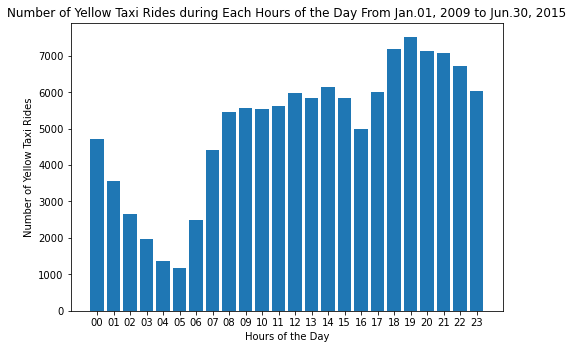

In [251]:
# Question 1
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
hour = []
rides = []
for tup in sorted(result):
    hour.append(tup[0])
    rides.append(tup[1])
ax.bar(hour,rides)
ax.set_ylabel('Number of Yellow Taxi Rides')
ax.set_xlabel('Hours of the Day')
ax.set_title('Number of Yellow Taxi Rides during Each Hours of the Day From Jan.01, 2009 to Jun.30, 2015')
plt.show()

### Q2

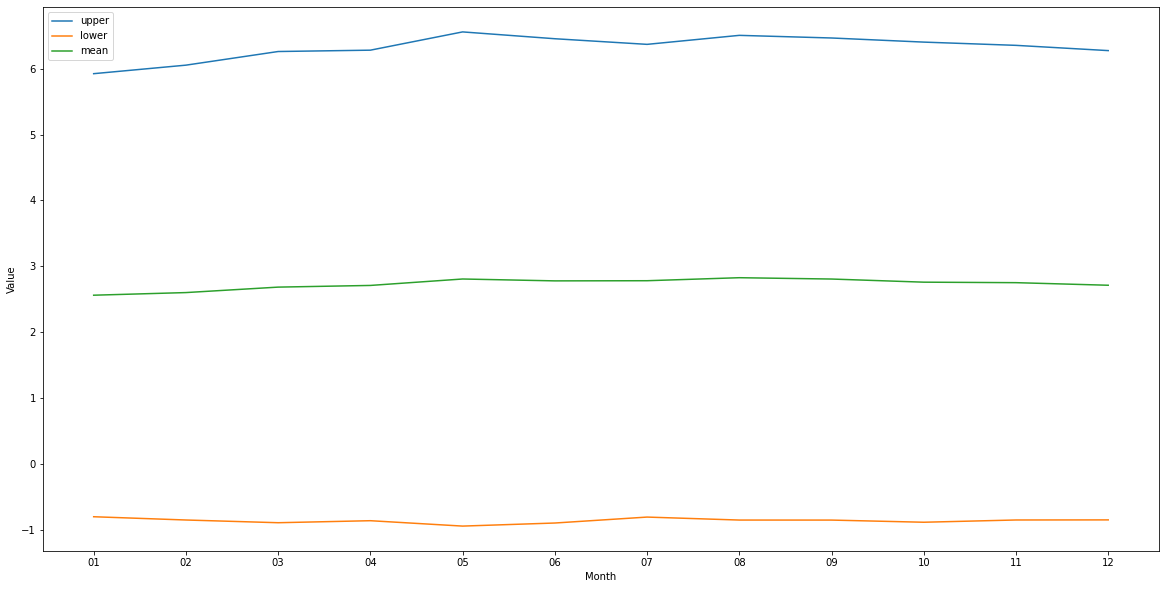

In [18]:
# use a more descriptive name for your function
def plot_visual_2():
    with connection:
        result = connection.execute("""
        select month_no, AVG(distance) as avg_dis, count(*)-1 as dof, avg(distance*distance) as avg_2_dis
        FROM
        (SELECT strftime('%m', DATE(SUBSTRING(pickup_datetime,1,19))) as month_no, distance 
        FROM uber_data
        where distance < 40
        UNION ALL
        SELECT strftime('%m', DATE(pickup_datetime)) as month_no, trip_distance as distance
        FROM taxi_data
        where distance < 40
        ) as t1
        group by month_no
        """
        )
    result = pd.DataFrame(result)
    result["lower"] = result.iloc[:,1] - (((result.iloc[:,3]-result.iloc[:,1]**2)/(result.iloc[:,2]+1))**(0.5)) * (np.abs(norm.ppf((1-0.9)/2,result.iloc[:,2]))) / np.sqrt(result.iloc[:,2]+1)
    result["upper"] = result.iloc[:,1] + (((result.iloc[:,3]-result.iloc[:,1]**2)/(result.iloc[:,2]+1))**(0.5)) * (np.abs(norm.ppf((1-0.9)/2,result.iloc[:,2]))) / np.sqrt(result.iloc[:,2]+1)
    result
    figure, axes = plt.subplots(figsize=(20, 10))
    plt.plot(result.iloc[:,0], result["upper"], label="upper")
    plt.plot(result.iloc[:,0], result["lower"], label="lower")
    plt.plot(result.iloc[:,0], result.iloc[:,1], label="mean")
    plt.legend()
    plt.xlabel("Month")
    plt.ylabel("Value")
    plt.show()
plot_visual_2()

### Q3

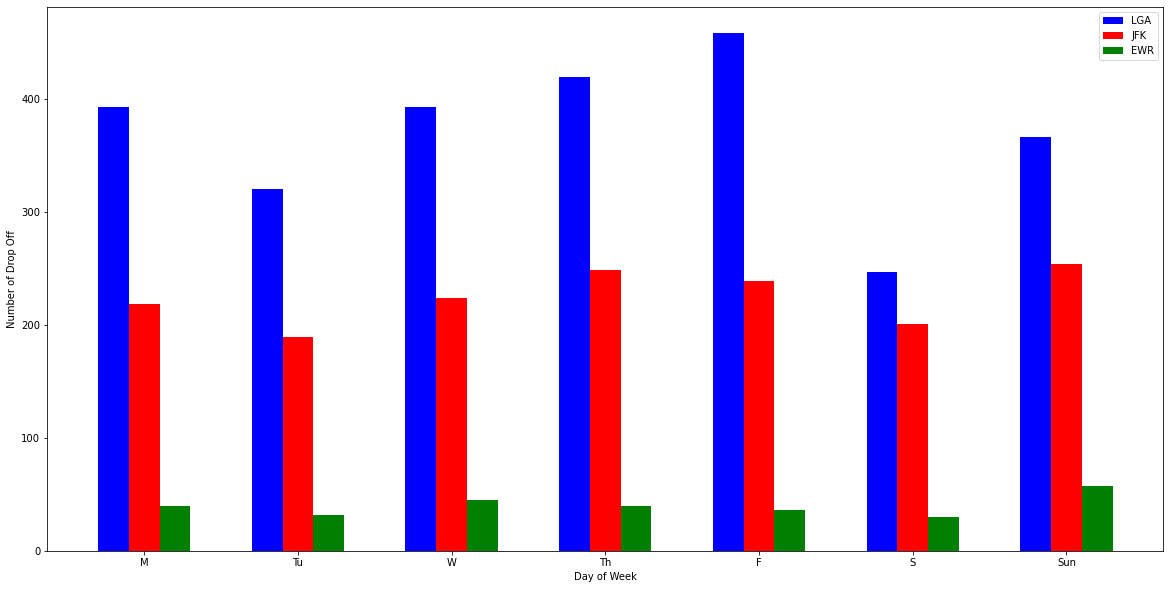

In [19]:
# use a more descriptive name for your function
LGA = [[-73.889494, -73.854904], [40.766892, 40.781646]]
JFK = [[-73.824263, -73.747873], [40.626982, 40.666252]]
EWR = [[-74.192820, -74.152822], [40.670613, 40.708751]]
def plot_visual_3():
    with connection:
        result = connection.execute("""
            select dayofweek, airport, count(*)
            from
            (SELECT distance,
            case cast (strftime('%w', DATE(SUBSTRING(pickup_datetime,1,19))) as integer)
              when 0 then 7
              when 1 then 1
              when 2 then 2
              when 3 then 3
              when 4 then 4
              when 5 then 5
              else 6 end as dayofweek,
            case 
                when (dropoff_latitude>40.766892 AND dropoff_latitude<40.781646 AND dropoff_longitude>-73.889494 AND dropoff_longitude<-73.854904) then 'LGA'
                when (dropoff_latitude>40.626982 AND dropoff_latitude<40.666252 AND dropoff_longitude>-73.824263 AND dropoff_longitude<-73.747873) then 'JFK'
                when (dropoff_latitude>40.670613 AND dropoff_latitude<40.708751 AND dropoff_longitude>-74.192820 AND dropoff_longitude<-74.152822) then 'EWR'
                else 'other' end as airport
            FROM uber_data
            WHERE (dropoff_latitude>40.766892 AND dropoff_latitude<40.781646 AND dropoff_longitude>-73.889494 AND dropoff_longitude<-73.854904)
            OR (dropoff_latitude>40.626982 AND dropoff_latitude<40.666252 AND dropoff_longitude>-73.824263 AND dropoff_longitude<-73.747873)
            OR (dropoff_latitude>40.670613 AND dropoff_latitude<40.708751 AND dropoff_longitude>-74.192820 AND dropoff_longitude<-74.152822)
            ) as tb1
            group by dayofweek, airport
            order by dayofweek ASC
            """
        )

    result = pd.DataFrame(result)
    result
    lga = result.loc[result[1] == 'LGA']
    jfk = result.loc[result[1] == 'JFK']
    ewr = result.loc[result[1] == 'EWR']
    barWidth=0.2
    br1 = np.arange(7)
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]
    figure, axes = plt.subplots(figsize=(20, 10))
    plt.bar(br1, lga.iloc[:,2], label="LGA", color ='blue',width = 0.2)
    plt.bar(br2, jfk.iloc[:,2], label="JFK", color ='red',width = 0.2)
    plt.bar(br3, ewr.iloc[:,2], label="EWR", color ='green',width = 0.2)
    plt.xticks([r + barWidth for r in range(7)], ['M', 'Tu', 'W', 'Th', 'F', 'S', 'Sun'])
    plt.legend()
    plt.xlabel("Day of Week")
    plt.ylabel("Number of Drop Off")
    plt.show()

plot_visual_3()

### Q4

In [20]:
conf = {'version': 'v1',
 'config': {'visState': {'filters': [],
   'layers': [{'id': 'j9yb0bb',
     'type': 'point',
     'config': {'dataId': 'uber_data',
      'label': 'pickup',
      'color': [18, 147, 154],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'pickup_latitude',
       'lng': 'pickup_longitude',
       'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 10,
       'fixedRadius': False,
       'opacity': 0.8,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'ps77bmt',
     'type': 'point',
     'config': {'dataId': 'uber_data',
      'label': 'dropoff',
      'color': [221, 178, 124],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'dropoff_latitude',
       'lng': 'dropoff_longitude',
       'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 10,
       'fixedRadius': False,
       'opacity': 0.8,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'e1x12yj',
     'type': 'arc',
     'config': {'dataId': 'uber_data',
      'label': 'pickup -> dropoff arc',
      'color': [146, 38, 198],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat0': 'pickup_latitude',
       'lng0': 'pickup_longitude',
       'lat1': 'dropoff_latitude',
       'lng1': 'dropoff_longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 0.8,
       'thickness': 2,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'sizeRange': [0, 10],
       'targetColor': None},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'w0xykl',
     'type': 'line',
     'config': {'dataId': 'uber_data',
      'label': 'pickup -> dropoff line',
      'color': [136, 87, 44],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat0': 'pickup_latitude',
       'lng0': 'pickup_longitude',
       'alt0': None,
       'lat1': 'dropoff_latitude',
       'lng1': 'dropoff_longitude',
       'alt1': None},
      'isVisible': False,
      'visConfig': {'opacity': 0.8,
       'thickness': 2,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'sizeRange': [0, 10],
       'targetColor': None,
       'elevationScale': 1},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'woabzwf',
     'type': 'heatmap',
     'config': {'dataId': 'uber_data',
      'label': 'heat',
      'color': [231, 159, 213],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'pickup_latitude', 'lng': 'pickup_longitude'},
      'isVisible': True,
      'visConfig': {'opacity': 0.8,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radius': 5.2},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'weightField': None, 'weightScale': 'linear'}}],
   'interactionConfig': {'tooltip': {'fieldsToShow': {'uber_data': [{'name': 'pickup_datetime',
        'format': None}]},
     'compareMode': False,
     'compareType': 'absolute',
     'enabled': False},
    'brush': {'size': 0.5, 'enabled': False},
    'geocoder': {'enabled': False},
    'coordinate': {'enabled': False}},
   'layerBlending': 'normal',
   'splitMaps': [],
   'animationConfig': {'currentTime': None, 'speed': 1}},
  'mapState': {'bearing': 0,
   'dragRotate': False,
   'latitude': 40.770618267185505,
   'longitude': -73.97792978691056,
   'pitch': 0,
   'zoom': 10.391854342929188,
   'isSplit': False},
  'mapStyle': {'styleType': 'dark',
   'topLayerGroups': {},
   'visibleLayerGroups': {'label': True,
    'road': True,
    'border': False,
    'building': True,
    'water': True,
    'land': True,
    '3d building': False},
   'threeDBuildingColor': [9.665468314072013,
    17.18305478057247,
    31.1442867897876],
   'mapStyles': {}}}}

In [21]:
# use a more descriptive name for your function
def plot_visual_4():
    uber_data_1 = uber_data.iloc[:,:5]
    map_1 = KeplerGl(height=500)
    map_1.add_data(data=uber_data_1,name='uber_data')
#     map_1 = KeplerGl(height=400, data=uber_data_1, config=conf)
    map_1.config = conf
    return map_1
plot_visual_4()

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'j9yb0bb', 'type': …

### Q5

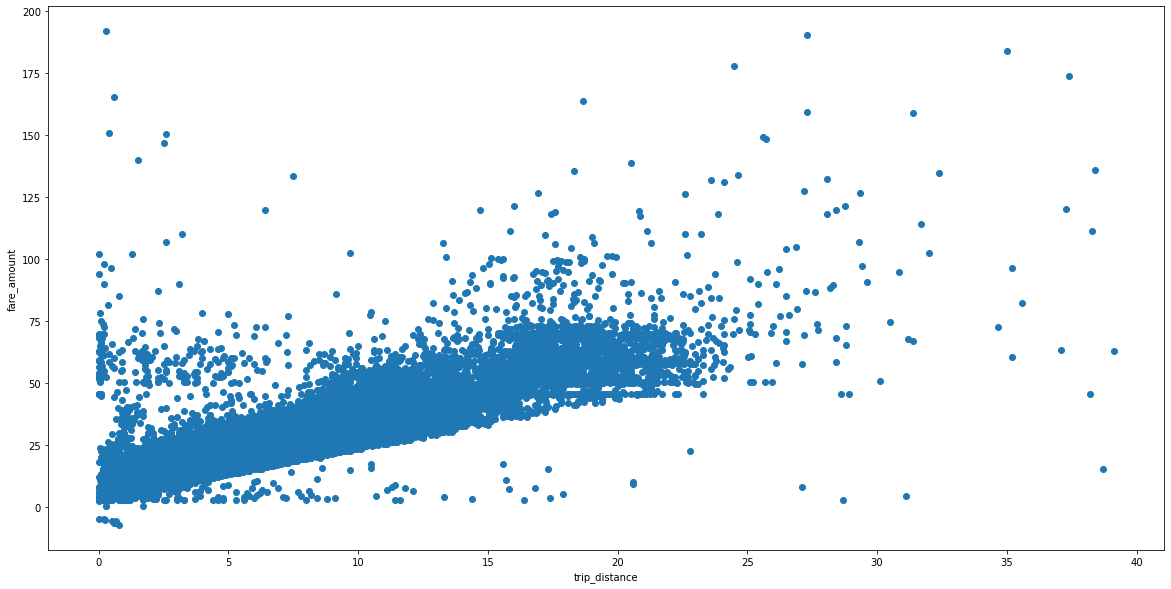

In [22]:
# use a more descriptive name for your function
def plot_visual_5():
    figure, axes = plt.subplots(figsize=(20, 10))
    with connection:
        result = connection.execute("""
        SELECT trip_distance, fare_amount 
        FROM taxi_data
        WHERE trip_distance != 0.0
        AND trip_distance < 40
        AND fare_amount != 0.0
        AND fare_amount < 200
        """
        )
    result = pd.DataFrame(result)
    result
    plt.scatter(result.iloc[:,0], result.iloc[:,1])
    plt.xlabel("trip_distance")
    plt.ylabel("fare_amount")
    plt.show()
plot_visual_5()

### Q6

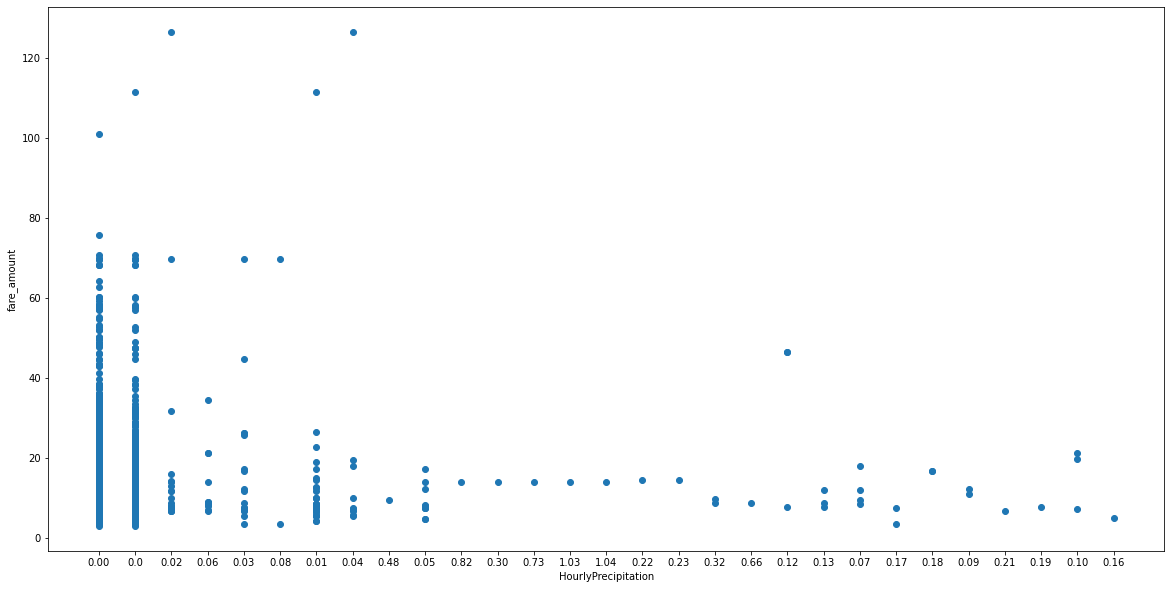

In [23]:
# use a more descriptive name for your function
def plot_visual_6():
    figure, axes = plt.subplots(figsize=(20, 10))
    
    with connection:
        result = connection.execute(
            """
            SELECT t1.date_time, t2.date_time, t1.fare_amount, t2.HourlyPrecipitation
            FROM
            (SELECT DATETIME(pickup_datetime) as date_time, fare_amount 
            FROM taxi_data) as t1
            JOIN
            (
            SELECT DATETIME(`DATE`) as date_time, HourlyPrecipitation
            FROM hourly_weather
            ) as t2
            ON t1.date_time < DATETIME(t2.date_time, '+30 minutes') and t1.date_time>DATETIME(t2.date_time, '-30 minutes')
            LIMIT 2000
            """
        )

    result = pd.DataFrame(result)
    result
    plt.scatter(result.iloc[:,3], result.iloc[:,2])
    plt.xlabel("HourlyPrecipitation")
    plt.ylabel("fare_amount")
    plt.show()
plot_visual_6()

### Q7

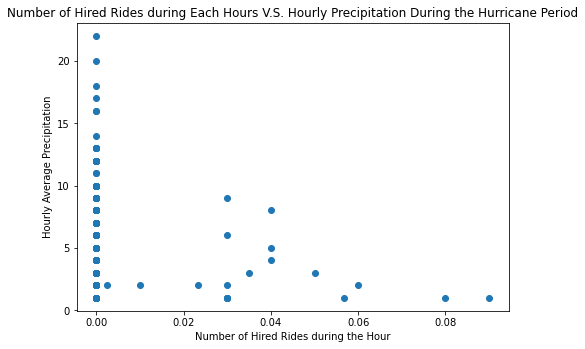

In [254]:
# Question 7.1
# Create Scatter Plot between Average Hourly Precipitation 
# and Number of Hired Rides during the Hurricane Period from Part 3
QUERY_7_1 = '''
        SELECT substr((substr(hr.`DATE`, 1, 10) || ' ' || substr(hr.`DATE`, 12)), 1, 13) AS H,
                t.c AS num_rides,
                avg(hr.HourlyPrecipitation) AS avg_hr_preci,
                avg(hr.HourlyWindSpeed) AS avg_hr_wind
        FROM hourly_weather as hr
        JOIN (
        SELECT Hour,
            COUNT(Hour) as c
        FROM(
        SELECT substr(a.pickup_datetime, 1, 13) AS Hour
        FROM taxi_data AS a
        WHERE a.pickup_datetime >= '2012-10-23 00:00:00'
        AND a.pickup_datetime <= '2012-10-30 23:59:59'
        AND a.trip_distance != 'None'
        UNION ALL 
        SELECT substr(datetime(substr(b.pickup_datetime, 1, 19)), 1,13) AS Hour
        FROM uber_data AS b
        WHERE b.pickup_datetime >= '2012-10-23 00:00:00'
        AND b.pickup_datetime <= '2012-10-30 23:59:59'
        )
        GROUP BY Hour
        ) as t
        ON H = Hour
        WHERE substr(hr.`DATE`, 1, 10) || ' ' || substr(hr.`DATE`, 12) >= '2012-10-23 00:00:00'
        AND substr(hr.`DATE`, 1, 10) || ' ' || substr(hr.`DATE`, 12) <= '2012-10-30 23:59:59'
        GROUP BY H
        '''
answer = engine.execute(QUERY_7_1).fetchall()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
prec = []
num_ride = []
for tup in answer:
    prec.append(tup[1])
    num_ride.append(tup[2])
plt.scatter(num_ride,prec)
ax.set_ylabel('Hourly Average Precipitation')
ax.set_xlabel('Number of Hired Rides during the Hour')
ax.set_title('Number of Hired Rides during Each Hours V.S. Hourly Precipitation During the Hurricane Period')
plt.show()

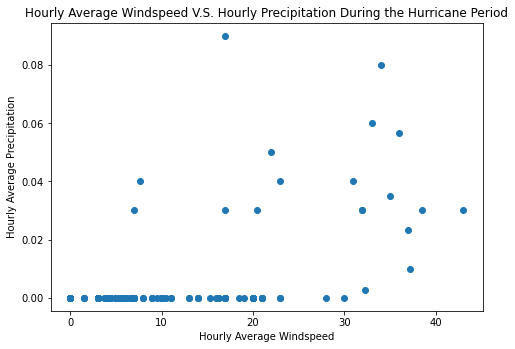

In [255]:
# Question 7.2
# Create Scatter Plot between Hourly Average Precipitation 
# and Hourly Average Windspeed during the Hurricane Period from Part 3
QUERY_7_2 = '''
        SELECT substr((substr(hr.`DATE`, 1, 10) || ' ' || substr(hr.`DATE`, 12)), 1, 13) AS H,
                t.c AS num_rides,
                avg(hr.HourlyPrecipitation) AS avg_hr_preci,
                avg(hr.HourlyWindSpeed) AS avg_hr_wind
        FROM hourly_weather as hr
        JOIN (
        SELECT Hour,
            COUNT(Hour) as c
        FROM(
        SELECT substr(a.pickup_datetime, 1, 13) AS Hour
        FROM taxi_data AS a
        WHERE a.pickup_datetime >= '2012-10-23 00:00:00'
        AND a.pickup_datetime <= '2012-10-30 23:59:59'
        AND a.trip_distance != 'None'
        UNION ALL 
        SELECT substr(datetime(substr(b.pickup_datetime, 1, 19)), 1,13) AS Hour
        FROM uber_data AS b
        WHERE b.pickup_datetime >= '2012-10-23 00:00:00'
        AND b.pickup_datetime <= '2012-10-30 23:59:59'
        )
        GROUP BY Hour
        ) as t
        ON H = Hour
        WHERE substr(hr.`DATE`, 1, 10) || ' ' || substr(hr.`DATE`, 12) >= '2012-10-23 00:00:00'
        AND substr(hr.`DATE`, 1, 10) || ' ' || substr(hr.`DATE`, 12) <= '2012-10-30 23:59:59'
        GROUP BY H
        '''
answer = engine.execute(QUERY_7_2).fetchall()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
prec_2 = []
num_ride_2 = []
for tup in answer:
    prec_2.append(tup[3])
    num_ride_2.append(tup[2])
plt.scatter(prec_2,num_ride_2)
ax.set_ylabel('Hourly Average Precipitation')
ax.set_xlabel('Hourly Average Windspeed')
ax.set_title('Hourly Average Windspeed V.S. Hourly Precipitation During the Hurricane Period')
plt.show()

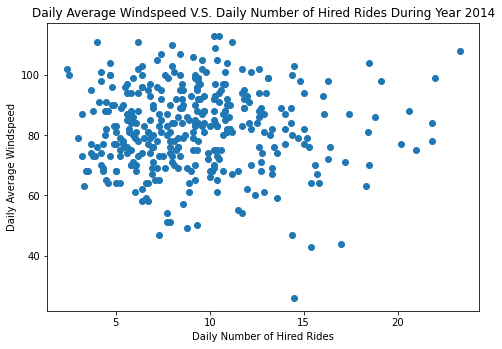

In [256]:
# Question 7.3
# Create Scatter Plot between Daily Average Windspeed 
# and Daily Total Number of Hired Rides during 2014
Q = '''
        SELECT strftime ('%Y-%m-%d',datetime(substr(c.`DATE`, 1, 10))) AS d,
            c.DailyAverageWindSpeed as WindSpeed,
            ride.num_ride
        FROM daily_weather as c
        JOIN(
        SELECT a_col,
                count(a_col) as num_ride
        FROM(
        SELECT strftime('%Y-%m-%d', a.pickup_datetime) AS a_col
        FROM taxi_data AS a
        WHERE a.pickup_datetime >= '2014-01-01 00:00:00'
        AND a.pickup_datetime <= '2014-12-31 23:59:59'
        AND a.trip_distance != 'None'
        UNION ALL 
        SELECT strftime ('%Y-%m-%d',datetime(substr(b.pickup_datetime, 1, 19))) AS a_col
        FROM uber_data AS b
        WHERE b.pickup_datetime >= '2014-01-01 00:00:00'
        AND b.pickup_datetime <= '2014-12-31 23:59:59'
        )
        GROUP BY a_col
        ) as ride
        ON d == ride.a_col
        WHERE d >= '2014-01-01 00:00:00'
        AND d <= '2014-12-31 23:59:59'
        GROUP BY d
        ORDER BY d
        '''
answer_1 = engine.execute(Q).fetchall()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
wind = []
num_ride_1 = []
for tup in answer_1:
    wind.append(tup[1])
    num_ride_1.append(tup[2])
plt.scatter(wind,num_ride_1)
ax.set_ylabel('Daily Average Windspeed')
ax.set_xlabel('Daily Number of Hired Rides')
ax.set_title('Daily Average Windspeed V.S. Daily Number of Hired Rides During Year 2014')
plt.show()

In [ ]:
plot_visual_n(some_dataframe)